# 模型选择、欠拟合和过拟合

通过多项式拟合来交互地探索这些概念

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

使用以下三阶多项式来生成训练和测试数据的标签：
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

看一下前2个样本

In [4]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 1.0640],
         [-0.9174]]),
 tensor([[ 1.0000e+00,  1.0640e+00,  5.6607e-01,  2.0077e-01,  5.3407e-02,
           1.1365e-02,  2.0155e-03,  3.0636e-04,  4.0747e-05,  4.8173e-06,
           5.1257e-07,  4.9581e-08,  4.3963e-09,  3.5983e-10,  2.7347e-11,
           1.9399e-12,  1.2901e-13,  8.0744e-15,  4.7730e-16,  2.6729e-17],
         [ 1.0000e+00, -9.1742e-01,  4.2083e-01, -1.2869e-01,  2.9517e-02,
          -5.4159e-03,  8.2811e-04, -1.0853e-04,  1.2446e-05, -1.2687e-06,
           1.1640e-07, -9.7077e-09,  7.4218e-10, -5.2376e-11,  3.4322e-12,
          -2.0992e-13,  1.2037e-14, -6.4957e-16,  3.3107e-17, -1.5986e-18]]),
 tensor([5.5848, 1.7862]))

实现一个函数来评估模型在给定数据集上的损失

In [5]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义训练函数

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

三阶多项式函数拟合(正态)

weight: [[ 5.008301   1.193439  -3.3986297  5.6132436]]


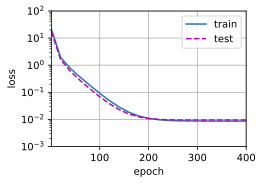

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

线性函数拟合(欠拟合)

weight: [[3.4483364 3.8339314]]


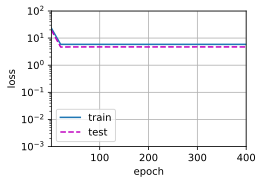

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

高阶多项式函数拟合(过拟合)

weight: [[ 4.9898586   1.2601213  -3.2784648   5.1874228  -0.46980542  1.3553324
   0.05445666  0.36175337  0.18168342 -0.05541486  0.03117955 -0.08055862
   0.13686389  0.02468539  0.01787525  0.07533484  0.09776107  0.00635211
   0.21766981 -0.02824796]]


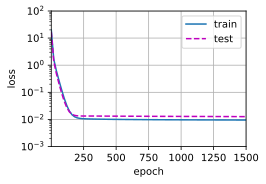

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)